# A second try at nowcasting model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config

config.update("jax_enable_x64", True)
from ssm4epi.models.hospitalization import (
    hospitalization_model,
    dates,
    unique_a,
    h_by_age,
    I_by_age,
)
from ssm4epi.models.util import from_consecutive_logits
from isssm.importance_sampling import mc_integration
from isssm.kalman import state_mode
from jax import vmap
from ssm4epi.patch import full_deps
import jax.numpy as jnp
from pyprojroot import here
import matplotlib.pyplot as plt
from isssm.estimation import initial_theta, mle_pgssm
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct
import jax.random as jrn
import pandas as pd
import fastcore.test as fct
from tqdm.notebook import tqdm

In [3]:
from typing import NamedTuple
from jaxtyping import Float, Array, PRNGKeyArray
from scipy.optimize import OptimizeResult
from isssm.typing import GLSSMProposal
from datetime import date

from ssm4epi.models.hospitalization import hospitalization_data

We focus on only nowcasting for the 00+ age group.

## Hospitalization and incidence data

In [4]:
hosp_data = hospitalization_data[hospitalization_data.a == "00+"]
h = hosp_data.pivot(index="s", columns="k", values="h").to_numpy()
I = hosp_data.pivot(index="s", columns="k", values="I").to_numpy()[:, 0]
dates = pd.to_datetime(hospitalization_data["s"].unique(), format="%Y-%m-%d").date

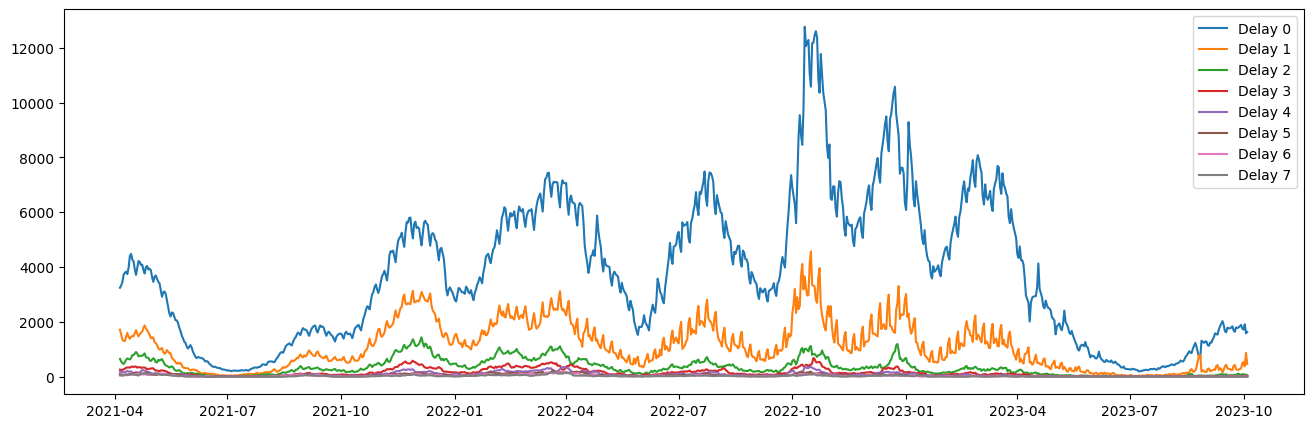

In [5]:
plt.figure(figsize=(16, 5))
plt.plot(pd.to_datetime(dates, format="%Y-%m-%d"), h)
plt.legend([f"Delay {i}" for i in range(h.shape[1])])
plt.show()

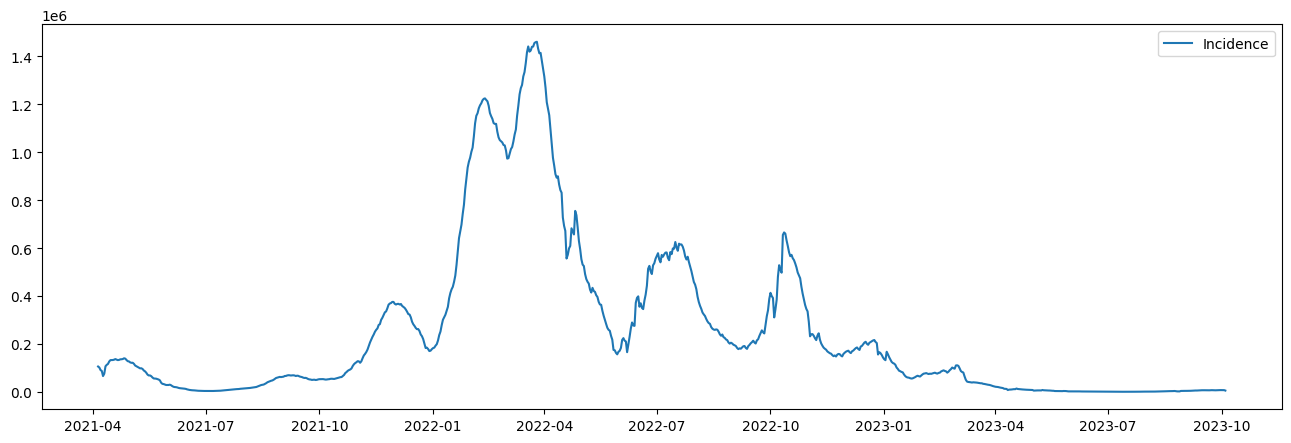

In [6]:
plt.figure(figsize=(16, 5))
plt.plot(pd.to_datetime(dates, format="%Y-%m-%d"), I)
plt.legend([f"Incidence"])
plt.show()

## Data structures

In [7]:
class PredictionResult(NamedTuple):
    mean: Float[Array, "..."]
    sd: Float[Array, "..."]
    quantiles: Float[Array, "k ..."]
    quantiles_of_interest: Float[Array, "k"]


class HospitalizationNowcastingResult(NamedTuple):
    a_index: int
    h: Float[Array, "..."]
    I: Float[Array, "..."]
    dates: pd.DatetimeIndex
    y_miss: Float[Array, "np1 p"]
    y_true: Float[Array, "np1 p"]
    theta0: Float[Array, "5"]
    theta0_result: OptimizeResult
    proposal: GLSSMProposal
    key: PRNGKeyArray
    ess_pct: Float
    y_sum_predict: PredictionResult

In [8]:
from ssm4epi.models.hospitalization import estimate_theta0_missing, LA_missing

- Parameter estimation
    - only for fully available observations
- LA for full missing model
- nowcasting

In [9]:
from jaxtyping import PRNGKeyArray


def find_index_of_date(dates: pd.DatetimeIndex, target_date: date) -> int:
    ((where,),) = jnp.where(dates == target_date)
    return int(where)

In [10]:
fct.test_eq(find_index_of_date(dates, dates[0]), 0)
fct.test_eq(find_index_of_date(dates, dates[-1]), len(dates) - 1)

In [ ]:
class Configuration(NamedTuple):
    dates: pd.DatetimeIndex
    n_delay: int  # number of delays
    key: PRNGKeyArray
    h: Float[Array, "n n_delay"]
    I: Float[Array, "n"]
    n: int
    n_weekday: int = 2  # number of weekday effects

    @classmethod
    def from_dates(cls, start: date, end: date, n_delay: int) -> "Configuration":
        i_start = find_index_of_date(dates, start)
        i_end = find_index_of_date(dates, end)
        h = hosp_data.pivot(index="s", columns="k", values="h").to_numpy()[
            i_start : (i_end + 1), :n_delay
        ]
        h = jnp.array(h)
        I = hosp_data.pivot(index="s", columns="k", values="I").to_numpy()[
            i_start : (i_end + 1), 0
        ]
        I = jnp.array(I)
        n, n_delay = h.shape

        return Configuration(
            dates=pd.date_range(start, end, freq="D"),
            n_delay=n_delay,
            key=jrn.PRNGKey(2423901241),
            h=h,
            I=I,
            n=n,
        )

In [12]:
start_date = date(2022, 1, 1)
end_date = date(2023, 1, 1)
config = Configuration.from_dates(start_date, end_date, n_delay=7)
fct.test_eq(config.dates[0].date(), start_date)
fct.test_eq(config.dates[-1].date(), end_date)
fct.test_eq(config.n_delay, 7)

In [13]:
from isssm.typing import GLSSM, PGSSM
from isssm.kalman import simulation_smoother
from functools import partial
from isssm.importance_sampling import log_weights


def pgssm_importance_sampling_missing(
    y: Float[Array, "n+1 p"],  # observations
    model: PGSSM,  # model
    z: Float[Array, "n+1 p"],  # synthetic observations
    Omega: Float[Array, "n+1 p p"],  # covariance of synthetic observations
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
) -> tuple[
    Float[Array, "N n+1 m"], Float[Array, "N"]
]:  # importance samples and weights
    u, A, D, Sigma0, Sigma, v, B, dist, xi = model

    missing_z_indices = jnp.isnan(z).any(axis=-1)
    if jnp.any(missing_z_indices):
        B = B.at[missing_z_indices].set(0.0)
        v = v.at[missing_z_indices].set(0.0)
        Omega = Omega.at[missing_z_indices].set(0.0)
        z = z.at[missing_z_indices].set(0.0)

    glssm = GLSSM(u, A, D, Sigma0, Sigma, v, B, Omega)

    key, subkey = jrn.split(key)
    s = simulation_smoother(glssm, z, N, subkey)

    model_log_weights = partial(log_weights, y=y, dist=dist, xi=xi, z=z, Omega=Omega)

    lw = vmap(model_log_weights)(s)

    return s, lw

In [ ]:
from ssm4epi.models.hospitalization import (
    account_for_nans,
    make_y_nan,
    estimate_theta0_missing,
    LA_missing,
)
from isssm.importance_sampling import prediction


def make_theta_manual(y, I):
    p0_hat = y[:7].sum() / I[:7].sum()

    exp_theta = jnp.array(
        [
            1**2,  # s2_p
            1**2,  # s2_q
            0.1**2,  # s2_W
            0.1**2,  # s2_0
            p0_hat,  # p0
        ]
    )

    theta_manual = jnp.log(exp_theta)
    return theta_manual


percentiles_of_interest = jnp.array([0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975])


class NowcastingDebuggingResult(NamedTuple):
    h: Float[Array, "n n_delay"]
    I: Float[Array, "n"]
    y_miss: Float[Array, "np1 p"]
    y_true: Float[Array, "np1 p"]
    theta_manual: Float[Array, "5"]
    theta0: Float[Array, "5"]
    theta0_result: OptimizeResult
    proposal: GLSSMProposal
    key: PRNGKeyArray
    ess_pct: Float


def nowcast_hospitalizations(config: Configuration):
    key = config.key
    h = config.h
    I = config.I

    np1, n_delay = h.shape
    n_weekday = config.n_weekday

    aux = (np1, n_delay, n_weekday, I)

    h_nan = make_y_nan(h)
    theta_manual = make_theta_manual(h_nan, I)
    theta0_result = estimate_theta0_missing(
        h_nan,
        theta_manual,
        aux=aux,
        I=I,
    )
    theta0 = theta0_result.x

    missing_y_indices = jnp.isnan(h_nan)
    missing_s_indicies = jnp.concatenate(
        (jnp.full((np1, 1), False, dtype=bool), missing_y_indices[:, :-1]), axis=-1
    )

    _, y_miss = account_for_nans(
        hospitalization_model(theta0, aux),
        h_nan,
        missing_y_indices,
        missing_s_indicies,
    )
    _model_miss = lambda theta, aux: account_for_nans(
        hospitalization_model(theta, aux), h_nan, missing_y_indices, missing_s_indicies
    )[0]
    model_miss0 = _model_miss(theta0, aux)
    proposal_la, info_la = LA_missing(y_miss, model_miss0, 100, eps=1e-10)

    nan_z_indices = jnp.isnan(proposal_la.z).any(axis=-1)
    if jnp.any(nan_z_indices):
        missing_y_indices = missing_y_indices.at[nan_z_indices].set(True)
        # where z is missing completely, s has to be missing as well
        missing_s_indicies = missing_s_indicies.at[nan_z_indices].set(True)

        _, y_miss = account_for_nans(
            hospitalization_model(theta0, aux),
            h_nan.at[nan_z_indices].set(jnp.nan),
            missing_y_indices,
            missing_s_indicies,
        )
        _model_miss = lambda theta, aux: account_for_nans(
            hospitalization_model(theta, aux),
            h_nan.at[nan_z_indices].set(jnp.nan),
            missing_y_indices,
            missing_s_indicies,
        )[0]
        model_miss0 = _model_miss(theta0, aux)
        proposal_la = proposal_la._replace(
            z=proposal_la.z.at[nan_z_indices].set(0.0),
            Omega=proposal_la.Omega.at[nan_z_indices].set(0.0),
        )

    key, subkey = jrn.split(key)
    samples, log_weights = pgssm_importance_sampling(
        y_miss,
        model_miss0,
        proposal_la.z,
        proposal_la.Omega,
        10000,
        subkey,
    )
    ess_pct_nowcast = ess_pct(log_weights)

    def f_nowcast(x, s, y):
        return jnp.sum(
            (missing_y_indices * y) + (1 - missing_y_indices) * y_miss, axis=-1
        )

    key, subkey = jrn.split(key)
    preds = prediction(
        f_nowcast,
        y_miss,
        proposal_la,
        _model_miss(theta0, aux),
        10000,
        subkey,
        percentiles_of_interest,
        hospitalization_model(theta0, aux),
    )
    debugging_result = NowcastingDebuggingResult(
        h=h,
        I=I,
        y_miss=y_miss,
        y_true=h_nan,
        theta_manual=theta_manual,
        theta0=theta0,
        theta0_result=theta0_result,
        proposal=proposal_la,
        key=key,
        ess_pct=ess_pct_nowcast,
    )
    return preds, debugging_result

In [90]:
from datetime import timedelta

date_start = date(2021, 11, 23)
n_days_back = 100

date_end = date(2022, 4, 29)

In [91]:
configs = [
    Configuration.from_dates(
        start=end - timedelta(days=n_days_back),
        end=end,
        n_delay=7,
    )._replace(n_weekday=0)
    for end in pd.date_range(date_start, date_end, freq="D").date
]

results = [nowcast_hospitalizations(config) for config in tqdm(configs)]

  0%|          | 0/158 [00:00<?, ?it/s]

: 

## Diagnostics

In [82]:
nan_dates = [
    str(date_start + timedelta(days=i))
    for i, (result) in enumerate(results)
    if jnp.isnan(result[0][-1])
]
REL_DIFF_THRESHOLD = 0.3
rel_diff_big_dates = [
    str(date_start + timedelta(days=i))
    for i, (result, config) in enumerate(zip(results, configs))
    if jnp.abs(result[0][-1] - config.h.sum(axis=-1)[-1]) / config.h.sum(axis=-1)[-1]
    > REL_DIFF_THRESHOLD
]

print(f"Dates with NaN results: {nan_dates}")
print(f"Dates with big relative differences: {len(rel_diff_big_dates)}")

Dates with NaN results: ['2022-08-11']
Dates with big relative differences: 30


In [84]:
# post-processing
# for nan results, rerun with configuration with n_weekday=0

for i, (config, result) in tqdm(enumerate(zip(configs, results))):
    true_h = config.h[-1].sum()
    predicted_mean_h = result[0][-1]
    abs_rel_diff = jnp.abs((predicted_mean_h - true_h) / true_h)
    if abs_rel_diff > REL_DIFF_THRESHOLD:
        print(f"Rerunning for {config.dates[-1]} with n_weekday=0")
        config = config._replace(n_weekday=0)
        result, debugging_info = nowcast_hospitalizations(config)
        results[i] = result

        predicted_mean_h = result[0][-1]
        abs_rel_diff = jnp.abs((predicted_mean_h - true_h) / true_h)
        print(
            f"New result for {config.dates[-1]}: {predicted_mean_h}, true h: {true_h}, rel diff: {abs_rel_diff}"
        )

0it [00:00, ?it/s]

Rerunning for 2021-12-02 00:00:00 with n_weekday=0
New result for 2021-12-02 00:00:00: 9819.808576317319, true h: 10232, rel diff: 0.04028454101668115
Rerunning for 2021-12-09 00:00:00 with n_weekday=0
New result for 2021-12-09 00:00:00: 11013.575017011477, true h: 10175, rel diff: 0.08241523508712305
Rerunning for 2022-02-06 00:00:00 with n_weekday=0
New result for 2022-02-06 00:00:00: 8074.097615740208, true h: 9355, rel diff: 0.13692168725385268
Rerunning for 2022-02-07 00:00:00 with n_weekday=0
New result for 2022-02-07 00:00:00: 9159.233606524445, true h: 9468, rel diff: 0.03261157514528461
Rerunning for 2022-03-06 00:00:00 with n_weekday=0
New result for 2022-03-06 00:00:00: 9185.286094649857, true h: 9172, rel diff: 0.001448549351270906
Rerunning for 2022-03-24 00:00:00 with n_weekday=0
New result for 2022-03-24 00:00:00: 11125.70464518987, true h: 11529, rel diff: 0.03498094846128289
Rerunning for 2022-03-29 00:00:00 with n_weekday=0
New result for 2022-03-29 00:00:00: 11811.19

KeyboardInterrupt: 

In [60]:
date_to_investigate = date(2021, 12, 4)

config = Configuration.from_dates(
    start=date_to_investigate - timedelta(days=n_days_back),
    end=date_to_investigate,
    n_delay=7,
)
config = config._replace(n_weekday=0)
result, debugging_info = nowcast_hospitalizations(config)
result[0][-1], result[1][-1], result[2][:, -1]

(Array(10214.00893297, dtype=float64),
 Array(680.32175682, dtype=float64),
 Array([ 8307.,  9540.,  9574., 10636., 10646., 10646., 10860.], dtype=float64))

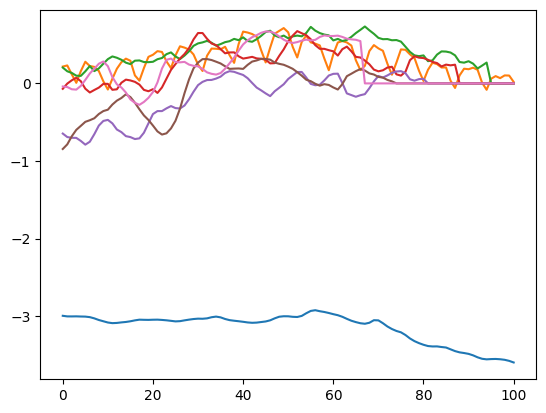

In [61]:
from isssm.laplace_approximation import posterior_mode

plt.plot(posterior_mode(debugging_info.proposal))

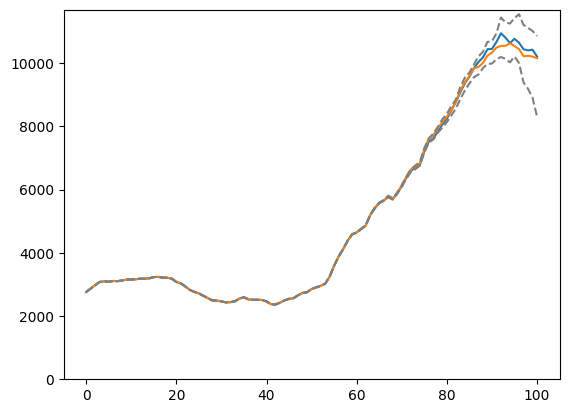

In [ ]:
plt.plot(result[0])
plt.plot(config.h.sum(axis=-1))
plt.plot(result[2][0], linestyle="--", color="gray")
plt.plot(result[2][-1], linestyle="--", color="gray")
plt.show()

## Prepare output

In [85]:
def result_to_series(result):
    (*_, mean), (*_, sd) = result[:2]

    quantiles = result[2][:, -1]

    quantile_names = [f"{p * 100:.1f} %" for p in percentiles_of_interest]

    ser = pd.Series(
        jnp.array([mean, sd, *quantiles]),
        index=["mean", "sd"] + quantile_names,
    )

    return ser

In [86]:
df = pd.concat(
    [
        result_to_series(result).to_frame().T.assign(date=date)
        for (result), date in zip(
            results, pd.date_range(date_start, date_end, freq="D").date
        )
    ]
).reset_index(drop=True)

In [87]:
df

,mean,sd,2.5 %,10.0 %,25.0 %,50.0 %,75.0 %,90.0 %,97.5 %,date
0,9924.819221,217.768947,9400.000000,9646.000000,9783.000000,9962.0,10133.00000,10184.0,10206.000000,2021-11-23
1,10380.228649,452.012002,9449.000000,10002.000000,10236.000000,10357.0,10377.00000,11270.0,11454.000000,2021-11-24
2,9938.245825,565.993988,9622.000000,9622.000000,9622.000000,9741.0,9741.00000,10975.0,11307.000000,2021-11-25
3,10287.936399,663.933208,9421.000000,9611.000000,9664.186002,10134.0,10688.00000,11236.0,11804.000000,2021-11-26
4,9941.978967,789.978665,8891.373377,8953.000000,9307.000000,9836.0,10455.00000,11315.0,11376.000000,2021-11-27
...,...,...,...,...,...,...,...,...,...,...
400,9157.216763,379.259969,8610.000000,8685.000000,8791.000000,9183.0,9245.00000,9546.0,10058.000000,2022-12-28
401,7629.000000,0.000000,7629.000000,7629.000000,7629.000000,7629.0,7629.00000,7629.0,7629.000000,2022-12-29
402,9160.083345,269.441754,8556.000000,8737.000000,9047.000000,9217.0,9345.00000,9391.0,9625.275487,2022-12-30
403,8442.505495,358.689895,7887.000000,8053.059233,8149.000000,8441.0,8734.00000,8923.0,9264.000000,2022-12-31


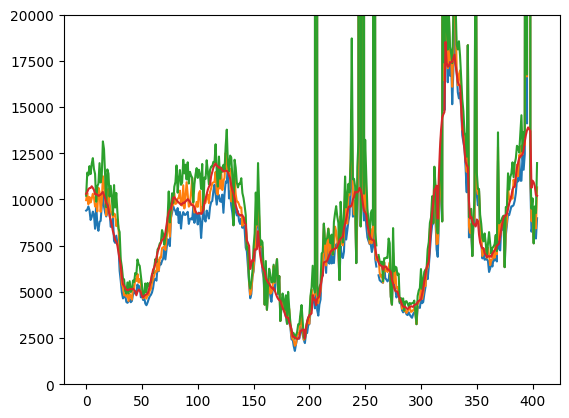

In [88]:
plt.plot(jnp.array([result[2][[0, 3, 6], -1] for result in results]))

plt.plot(
    h[
        find_index_of_date(dates, date_start) : find_index_of_date(
            dates, date_end + timedelta(days=1)
        )
    ].sum(axis=1),
)
plt.ylim(0, 20000)
plt.show()

In [89]:
df.to_csv(here("data/results/4_hospitalizations/nowcast/nowcast.csv"), index=False)